## Data Interpreation and Understanding Information

Imports + plotting discipline

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plot aesthetics (keep it clean, not fancy)
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")


Load Datasets

In [2]:
# Load datasets
stores = pd.read_csv(r"walmart/stores.csv")
features = pd.read_csv(r"walmart/features.csv")
train = pd.read_csv(r"walmart/train.csv")

# Quick sanity check
print("Stores shape:", stores.shape)
print("Features shape:", features.shape)
print("Train shape:", train.shape)


Stores shape: (45, 3)
Features shape: (8190, 12)
Train shape: (421570, 5)


Understanding Schema

In [3]:
# Column overview
print("Stores columns:\n", stores.columns, "\n")
print("Features columns:\n", features.columns, "\n")
print("Train columns:\n", train.columns)


Stores columns:
 Index(['Store', 'Type', 'Size'], dtype='object') 

Features columns:
 Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object') 

Train columns:
 Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')


EDA PART 1: stores.csv

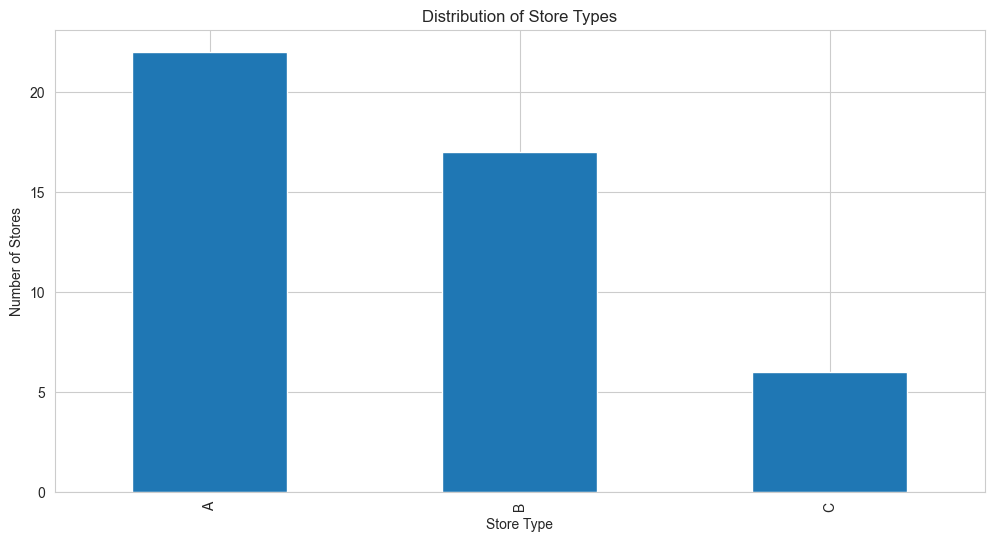

In [4]:
# Store count by type
store_type_counts = stores["Type"].value_counts()

store_type_counts.plot(kind="bar")
plt.title("Distribution of Store Types")
plt.xlabel("Store Type")
plt.ylabel("Number of Stores")
plt.show()


In [5]:
# Preview store metadata
stores.head()


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


# EDA PART 2 — features.csv

Date handling

In [7]:
# Robust datetime parsing (handles day-first format)
features["Date"] = pd.to_datetime(features["Date"], dayfirst=True)
train["Date"] = pd.to_datetime(train["Date"], dayfirst=True)



In [8]:
# Time range check
print("Features date range:", features["Date"].min(), "to", features["Date"].max())
print("Train date range:", train["Date"].min(), "to", train["Date"].max())


Features date range: 2010-02-05 00:00:00 to 2013-07-26 00:00:00
Train date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


Holiday signal analysis

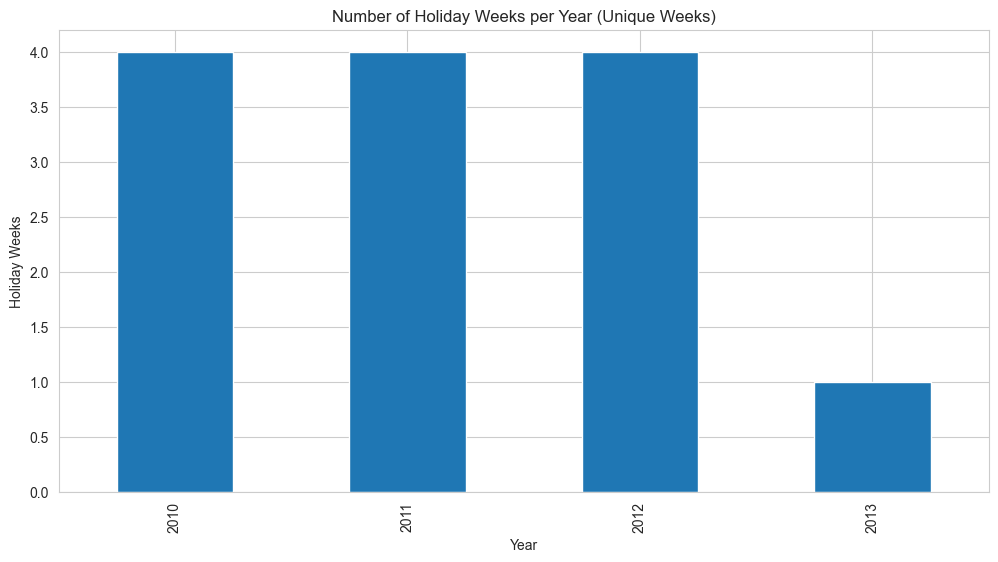

In [10]:
# Holiday frequency over time
# Count unique holiday weeks per year (deduplicated across stores)
holiday_weeks = (
    features[["Date", "IsHoliday"]]
    .drop_duplicates()
    .groupby(features["Date"].dt.year)["IsHoliday"]
    .sum()
)

holiday_weeks.plot(kind="bar")
plt.title("Number of Holiday Weeks per Year (Unique Weeks)")
plt.xlabel("Year")
plt.ylabel("Holiday Weeks")
plt.show()



Temperature trend (slow drift evidence)

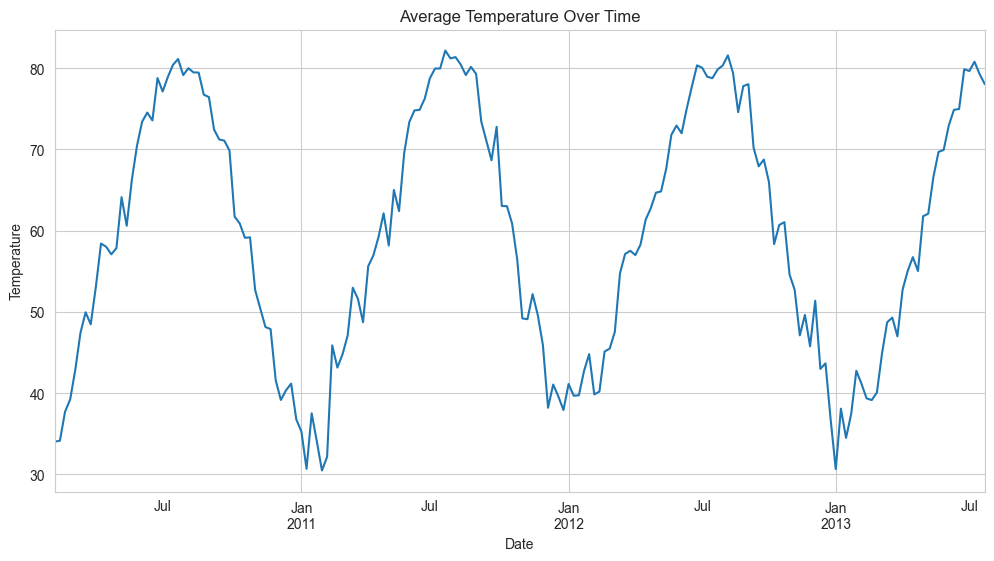

In [11]:
# Average temperature over time
temp_trend = features.groupby("Date")["Temperature"].mean()

temp_trend.plot()
plt.title("Average Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()


Fuel price drift

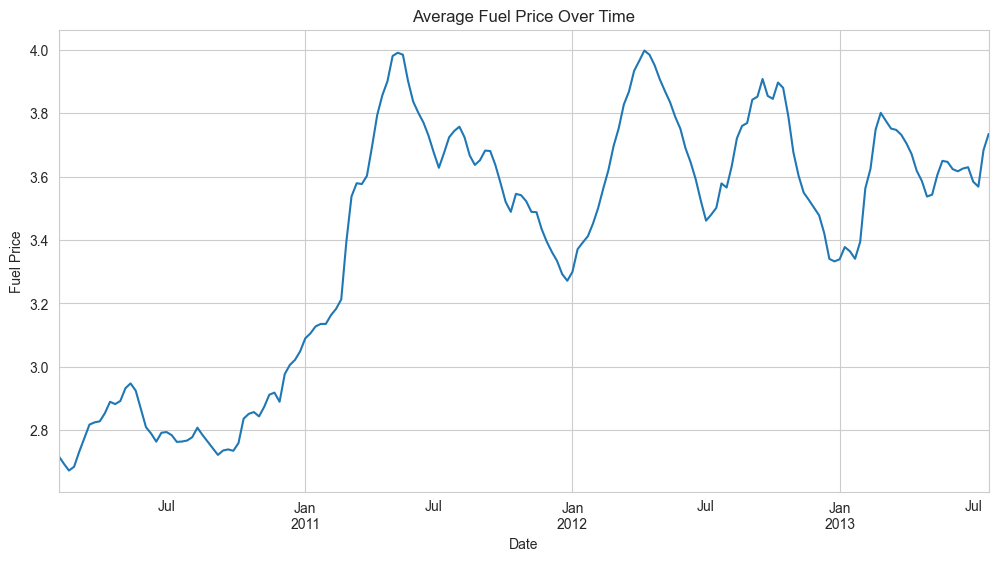

In [12]:
# Fuel price trend
fuel_trend = features.groupby("Date")["Fuel_Price"].mean()

fuel_trend.plot()
plt.title("Average Fuel Price Over Time")
plt.xlabel("Date")
plt.ylabel("Fuel Price")
plt.show()


Missing data analysis

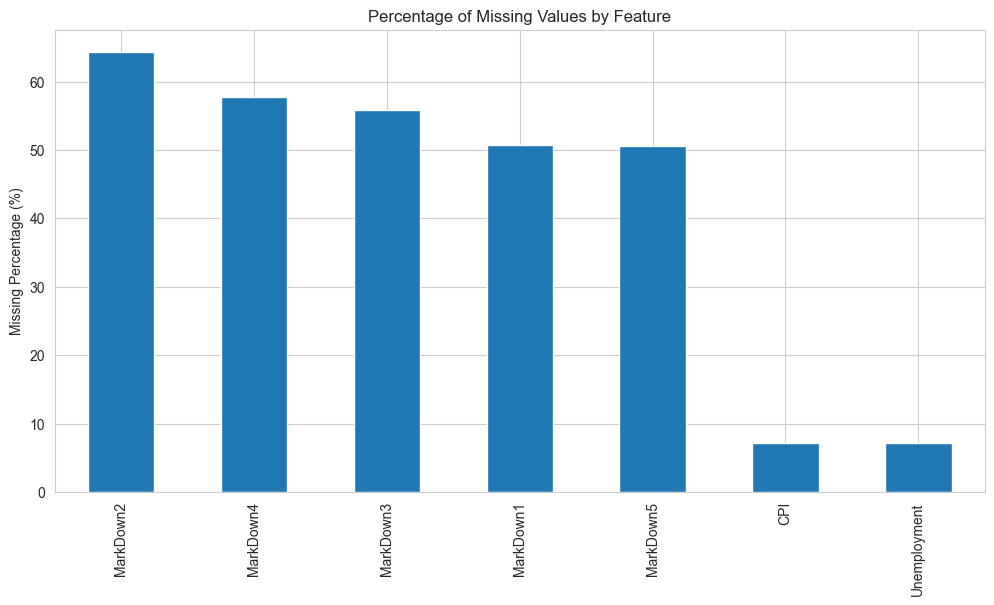

In [13]:
# Missing value percentage
missing_pct = features.isna().mean() * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

missing_pct.plot(kind="bar")
plt.title("Percentage of Missing Values by Feature")
plt.ylabel("Missing Percentage (%)")
plt.show()


# Exploratory Analysis: Structural and Exogenous Context
## Store-Level Structure

The distribution of store types reveals clear structural heterogeneity across the retail network. Stores are categorized into three distinct types (A, B, and C), with Type A and Type B constituting the majority of locations, while Type C represents a smaller subset. This heterogeneity suggests that stores operate under differing demand scales and operational characteristics, motivating store-specific inventory decisions rather than a single uniform replenishment policy.

## Exogenous Features and Partial Observability

The feature dataset provides a set of external signals that may influence demand and operational conditions, including holidays, temperature, fuel price, and macroeconomic indicators.

### Holiday Indicators.
After accounting for duplicate records across stores, holidays occur only during a small number of unique calendar weeks per year. This sparsity indicates that while holidays may cause localized demand spikes, they are insufficient to fully explain long-term demand variability. Consequently, decision systems relying on holiday indicators alone remain exposed to unmodeled demand dynamics.

### Temperature Trends.
Average temperature exhibits strong seasonal patterns with consistent annual cycles. While temperature follows a predictable structure, it varies continuously over time and differs across regions. Such slow-moving environmental variation contributes to non-stationary operating conditions that classical inventory models do not explicitly accommodate.

### Fuel Price Drift.
Fuel prices display gradual temporal drift with multi-month trends and regime changes. Although fuel price does not directly determine inventory demand, it acts as a proxy for evolving operational costs and broader economic conditions. This gradual drift introduces long-term pressure on decision systems without triggering abrupt performance failures.

### Missing Data in Promotional Features.
Promotional variables (MarkDown1–MarkDown5) exhibit substantial missing values, exceeding 50% in several cases. This highlights a key characteristic of real-world operational systems: external signals are often incomplete and inconsistently observed. As a result, the decision-making system must operate under partial observability, relying on imperfect and delayed information.

## Summary Observations

* The retail system exhibits structural heterogeneity across store types.
* External signals such as holidays, weather, and fuel prices provide partial but incomplete context.
* Several potentially informative features suffer from significant missing data.
* Operating conditions evolve gradually over time rather than through abrupt shocks.

These observations collectively justify the use of adaptive state estimation techniques and motivate the study of silent decision degradation under realistic uncertainty.

# EDA PART 3 — Demand Dynamics (train.csv)

In [16]:
# Basic info
print("Train shape:", train.shape)
train.head()


Train shape: (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


The demand dataset contains weekly sales observations indexed by store, department, and time, forming a high-dimensional panel of repeated decision outcomes.

Global demand over time

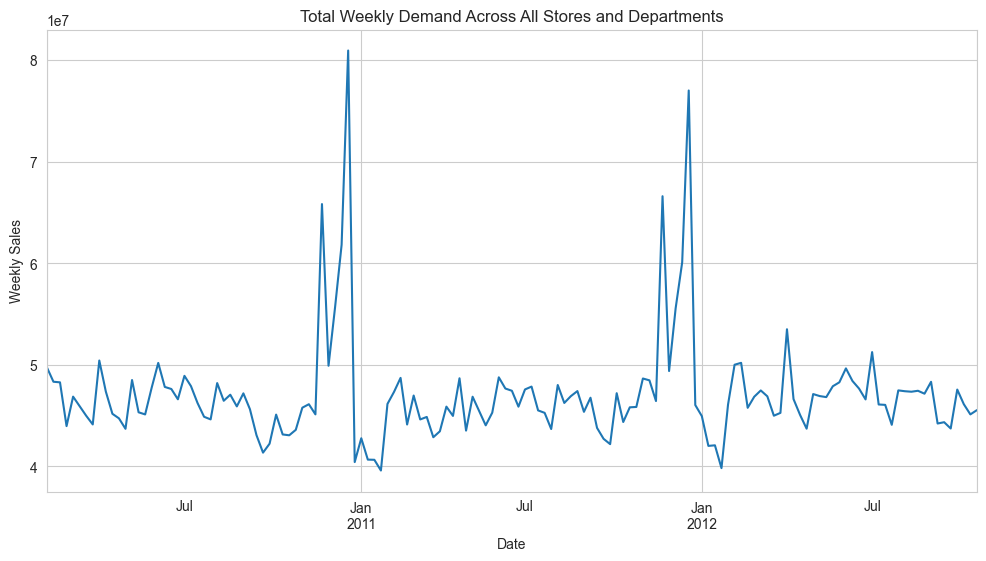

In [17]:
# Aggregate total weekly demand across all stores and departments
global_demand = train.groupby("Date")["Weekly_Sales"].sum()

global_demand.plot()
plt.title("Total Weekly Demand Across All Stores and Departments")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()


### Aggregate Demand Behavior.
Total weekly demand exhibits strong seasonal structure punctuated by sharp holiday-driven spikes. These high-magnitude but short-duration demand surges are followed by rapid reversion toward baseline levels. Such behavior implies that inventory decisions must account for rare but impactful events while operating under uncertainty regarding their exact timing and magnitude. Importantly, these effects are not persistent enough to be captured reliably through simple averaging, creating conditions where decision quality may degrade without obvious performance collapse.

Year-wise comparison (drift evidence)

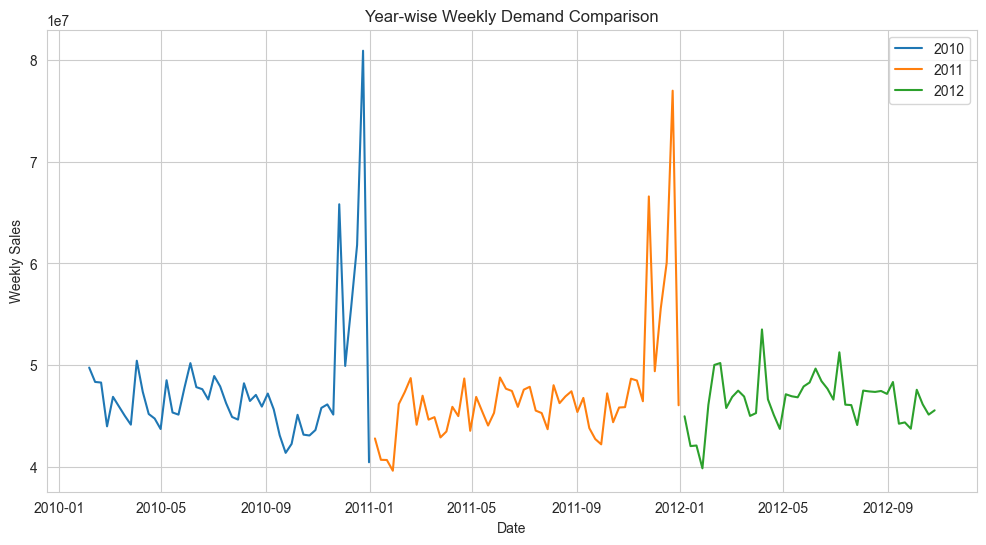

In [18]:
# Add year column
train["Year"] = train["Date"].dt.year

# Plot year-wise total demand
plt.figure(figsize=(12, 6))
for year, df in train.groupby("Year"):
    yearly = df.groupby("Date")["Weekly_Sales"].sum()
    plt.plot(yearly.index, yearly.values, label=str(year))

plt.title("Year-wise Weekly Demand Comparison")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


### Inter-Annual Demand Variability.
While aggregate demand exhibits recurring seasonal structure, year-wise comparisons reveal substantial differences in both the magnitude and recovery patterns of holiday-driven demand spikes. Baseline demand levels also vary gradually across years without abrupt regime changes. This indicates that historical seasonal patterns provide incomplete guidance for future decisions, as similar calendar periods can produce materially different demand realizations. Such inter-annual variability creates conditions where inventory policies calibrated on past data remain operationally plausible while becoming progressively misaligned.

Store-level heterogeneity (decision granularity)

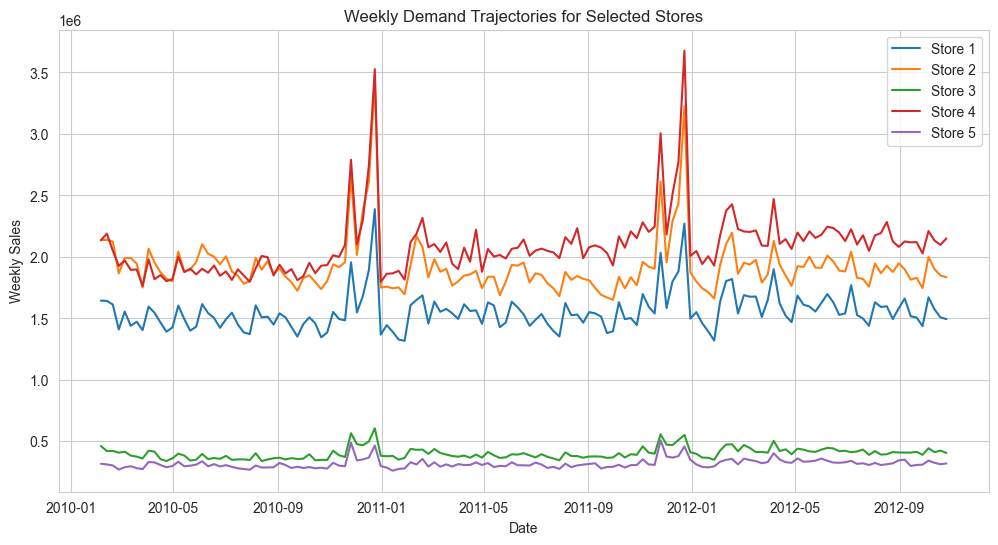

In [19]:
# Select a few representative stores
sample_stores = train["Store"].unique()[:5]

plt.figure(figsize=(12, 6))
for store in sample_stores:
    store_demand = (
        train[train["Store"] == store]
        .groupby("Date")["Weekly_Sales"]
        .sum()
    )
    plt.plot(store_demand.index, store_demand.values, label=f"Store {store}")

plt.title("Weekly Demand Trajectories for Selected Stores")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


### Store-Level Demand Heterogeneity.
Weekly demand trajectories differ substantially across stores in both magnitude and temporal response. High-volume stores exhibit pronounced holiday-driven spikes and greater volatility, while lower-volume stores display comparatively muted responses and narrower demand ranges. Additionally, baseline demand levels evolve differently across stores over time. These observations indicate that aggregate performance metrics can obscure localized demand shifts, creating conditions where store-level inventory decisions degrade without triggering global performance alarms.

Product / department heterogeneity (risk profiles)

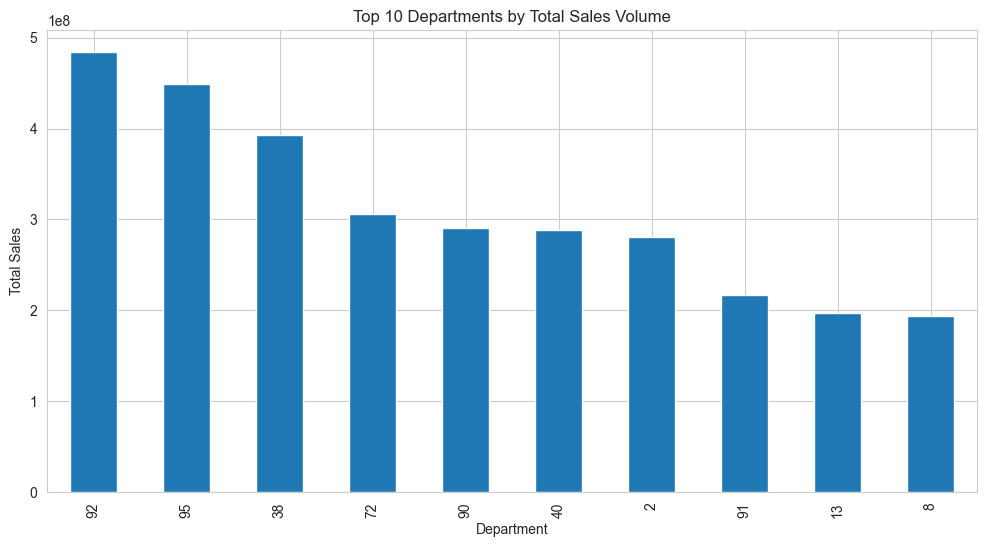

In [20]:
# Demand distribution by department
dept_demand = train.groupby("Dept")["Weekly_Sales"].sum()

dept_demand.sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Departments by Total Sales Volume")
plt.xlabel("Department")
plt.ylabel("Total Sales")
plt.show()


### Department-Level Demand Concentration.
Sales volume is unevenly distributed across departments, with a small subset accounting for a large fraction of total demand. While high-volume departments dominate aggregate performance metrics, lower-volume departments remain operationally critical due to their higher relative volatility and sensitivity to forecasting errors. This imbalance implies that inventory decision systems optimized for aggregate performance may remain apparently stable while exhibiting persistent degradation at the product level.

Rolling mean & variance

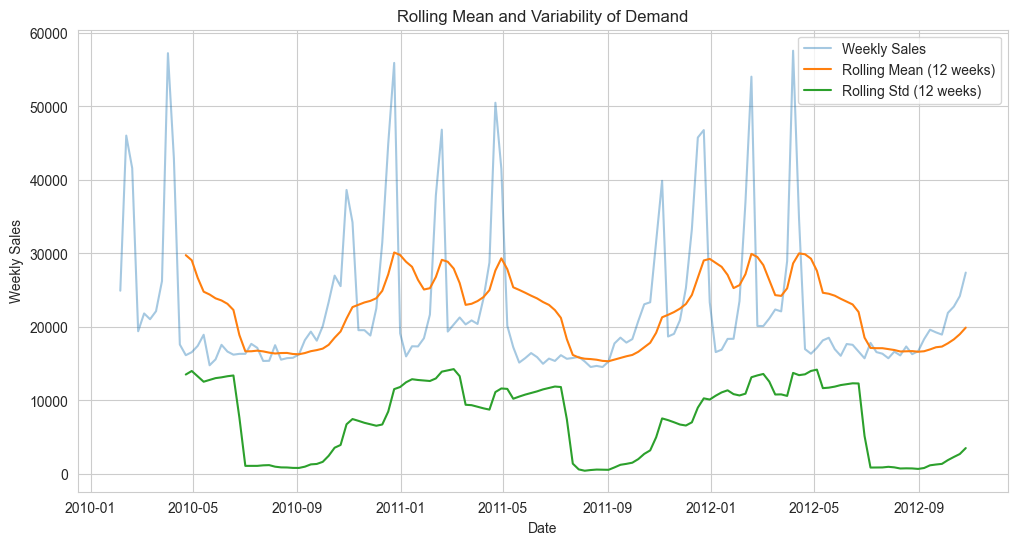

In [21]:
# Select one store-department pair for clarity
example = train[(train["Store"] == sample_stores[0]) & (train["Dept"] == train["Dept"].unique()[0])]
example = example.sort_values("Date")

# Rolling statistics
rolling_mean = example["Weekly_Sales"].rolling(window=12).mean()
rolling_std = example["Weekly_Sales"].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(example["Date"], example["Weekly_Sales"], alpha=0.4, label="Weekly Sales")
plt.plot(example["Date"], rolling_mean, label="Rolling Mean (12 weeks)")
plt.plot(example["Date"], rolling_std, label="Rolling Std (12 weeks)")
plt.title("Rolling Mean and Variability of Demand")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


### Non-Stationarity of Demand and Uncertainty.
Rolling statistics for individual store–department pairs reveal that both the expected demand level and its variability evolve over time. While seasonal structure is present, neither the mean nor the variance remains constant across comparable periods. Importantly, changes in demand variability are not strictly coupled to changes in average demand, indicating regime shifts in uncertainty. Such behavior violates the assumptions of static inventory control models and creates conditions where replenishment decisions may remain plausible while becoming progressively misaligned.

Demand volatility over time

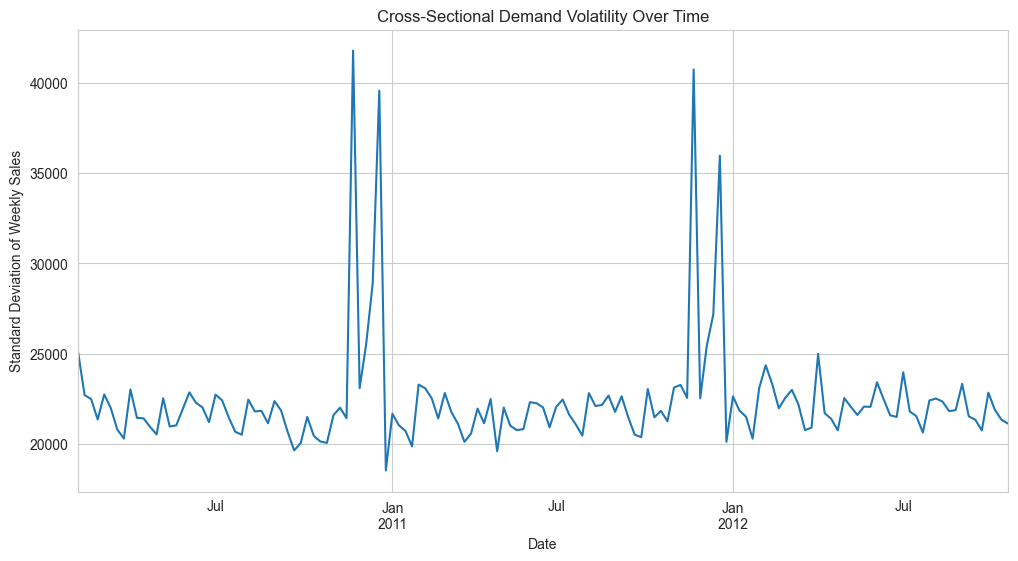

In [22]:
# Demand volatility over time (global)
weekly_std = train.groupby("Date")["Weekly_Sales"].std()

weekly_std.plot()
plt.title("Cross-Sectional Demand Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Standard Deviation of Weekly Sales")
plt.show()


### System-Level Demand Volatility.
Cross-sectional demand volatility exhibits pronounced temporal variation, characterized by sharp but transient spikes during peak periods and gradual shifts in baseline risk levels over time. Notably, these changes in system-wide uncertainty occur even when average demand remains relatively stable. This indicates that operational risk evolves independently of conventional performance metrics, creating conditions under which inventory decisions can degrade silently without triggering immediate alarms.

# EDA 4 — Combined Cross-Table Environmental Analysis

To demonstrate how demand outcomes, exogenous signals, and structural attributes interact over time — without using this information to optimize decisions.

In [24]:
eda_df = (
    train
    .merge(features, on=["Store", "Date"], how="left")
    .merge(stores, on="Store", how="left")
)


### Average demand on holiday vs non-holiday weeks

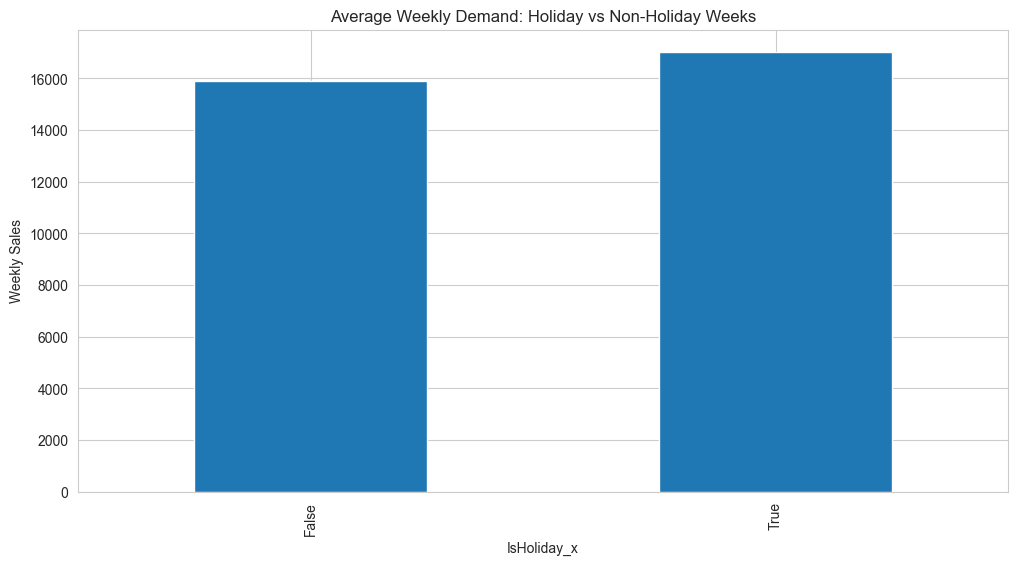

In [25]:
holiday_effect = eda_df.groupby("IsHoliday_x")["Weekly_Sales"].mean()

holiday_effect.plot(kind="bar")
plt.title("Average Weekly Demand: Holiday vs Non-Holiday Weeks")
plt.ylabel("Weekly Sales")
plt.show()


### Observation.
Average weekly demand is higher during holiday weeks compared to non-holiday weeks. However, the magnitude of the increase is moderate rather than extreme.

### Interpretation.
This indicates that holidays act as a demand amplifier but do not fully dominate demand behavior. While holiday indicators explain part of the demand variation, they are insufficient as a standalone explanatory signal.

### Implication.
Inventory policies relying solely on holiday flags risk underestimating demand variability and overestimating predictability during peak periods.

# Distribution of demand during holidays vs non-holidays

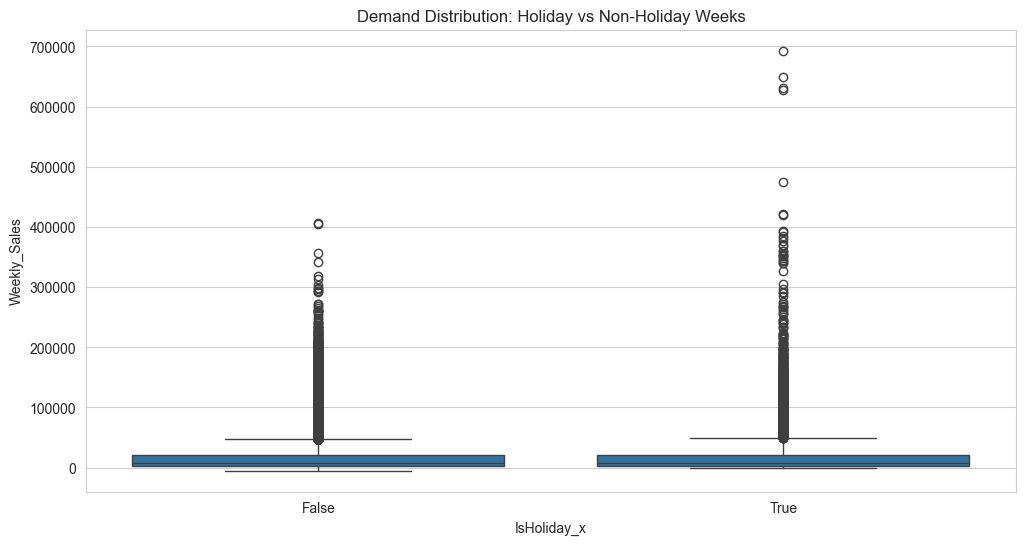

In [26]:
sns.boxplot(x="IsHoliday_x", y="Weekly_Sales", data=eda_df)
plt.title("Demand Distribution: Holiday vs Non-Holiday Weeks")
plt.show()


### Observation.
Demand distributions for holiday and non-holiday weeks overlap substantially, with holiday weeks exhibiting heavier upper tails and higher dispersion.

### Interpretation.
Although holiday weeks increase the probability of extreme demand realizations, many non-holiday weeks exhibit comparable demand levels. This overlap suggests that demand risk is not confined to clearly labeled peak periods.

### Implication.
Binary holiday-based adjustments to inventory decisions are insufficient to capture tail risk and can mask gradual degradation in service performance.

## Demand vs Temperature (Sampled Scatter Plot)

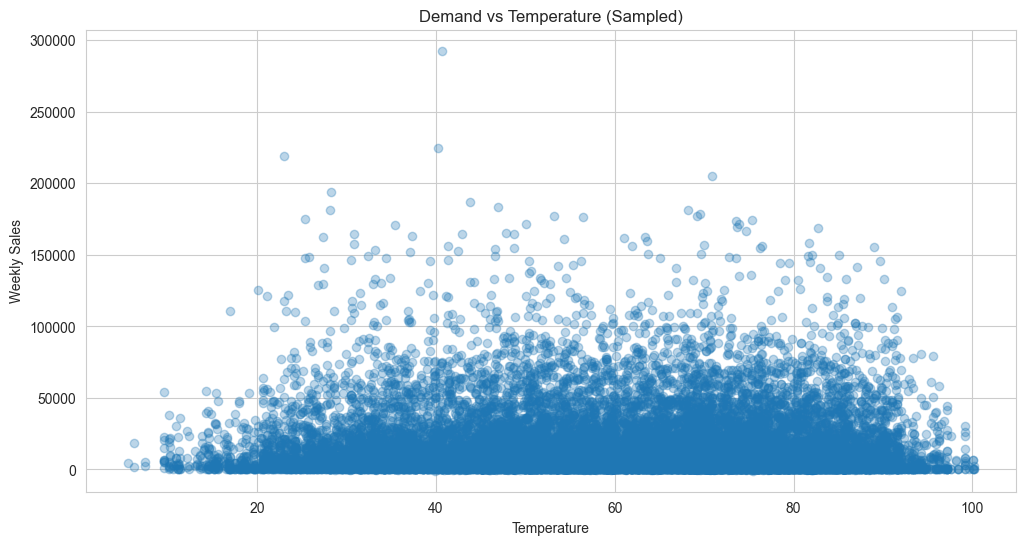

In [27]:
sample = eda_df.sample(20000, random_state=42)

plt.scatter(sample["Temperature"], sample["Weekly_Sales"], alpha=0.3)
plt.xlabel("Temperature")
plt.ylabel("Weekly Sales")
plt.title("Demand vs Temperature (Sampled)")
plt.show()


### Observation.
Weekly demand shows a weak and highly dispersed relationship with temperature. Similar temperature values correspond to a wide range of demand outcomes.

### Interpretation.
Temperature exhibits limited direct explanatory power for demand at the weekly resolution. The large dispersion highlights partial observability, where external signals provide incomplete and noisy information about actual demand drivers.

### Implication.
Decision systems that assume strong or linear dependence on environmental variables may develop false confidence, leading to miscalibrated inventory decisions.

## Seasonal Alignment: Demand vs Temperature Over Time

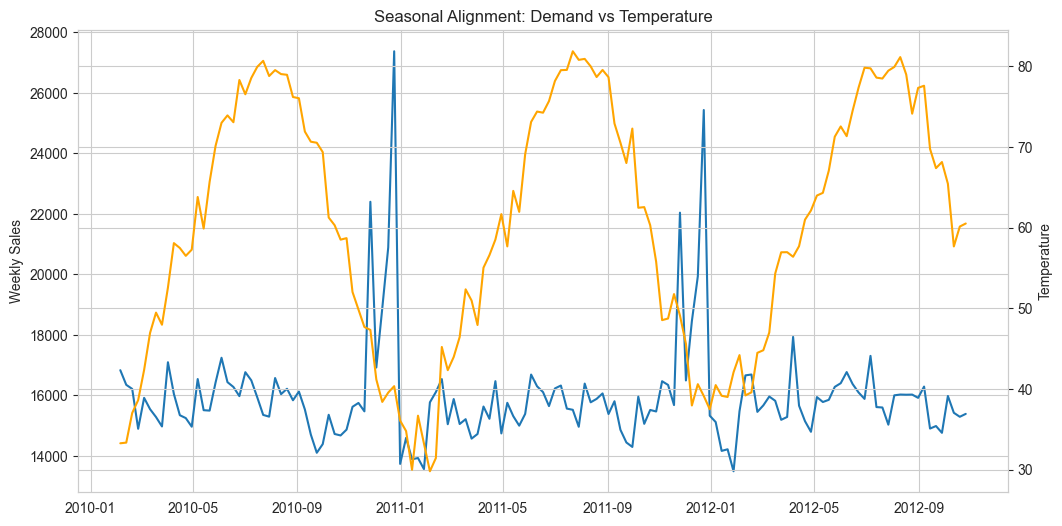

In [28]:
weekly_avg = eda_df.groupby("Date")[["Weekly_Sales", "Temperature"]].mean()

fig, ax1 = plt.subplots()

ax1.plot(weekly_avg.index, weekly_avg["Weekly_Sales"], label="Demand")
ax1.set_ylabel("Weekly Sales")

ax2 = ax1.twinx()
ax2.plot(weekly_avg.index, weekly_avg["Temperature"], color="orange", label="Temperature")
ax2.set_ylabel("Temperature")

plt.title("Seasonal Alignment: Demand vs Temperature")
plt.show()


## Observation.
Both demand and temperature exhibit seasonal patterns, but their peaks and troughs are not consistently aligned in timing or magnitude.

## Interpretation.
Seasonality exists but manifests differently across variables. Demand responds nonlinearly and with variable lag to seasonal factors, rather than following a fixed seasonal template.

## Implication.
Static seasonal adjustments are insufficient for reliable decision-making, as they fail to capture shifts in timing and intensity across years.

## Demand Distribution by Store Type

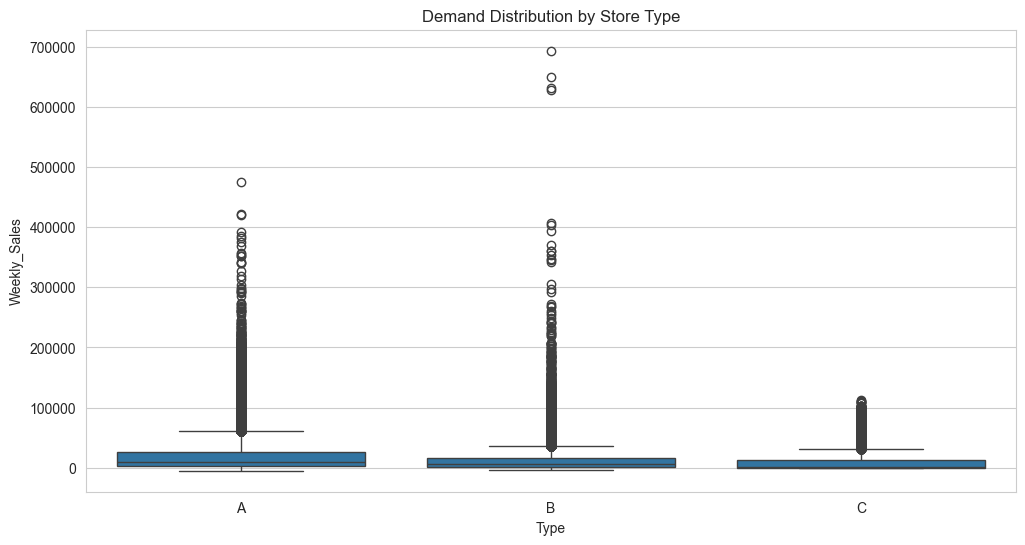

In [29]:
sns.boxplot(x="Type", y="Weekly_Sales", data=eda_df)
plt.title("Demand Distribution by Store Type")
plt.show()

### Observation.
Demand distributions differ significantly across store types. Larger store types exhibit wider ranges and heavier upper tails, while smaller store types show lower absolute demand and tighter distributions.

### Interpretation.
Structural attributes such as store type fundamentally shape demand behavior. These differences persist across time and are not explained by temporal factors alone.

### Implication.
Uniform inventory policies across heterogeneous store types can lead to systematic overstocking in some contexts and persistent stockouts in others.

# Demand Volatility by Store Type

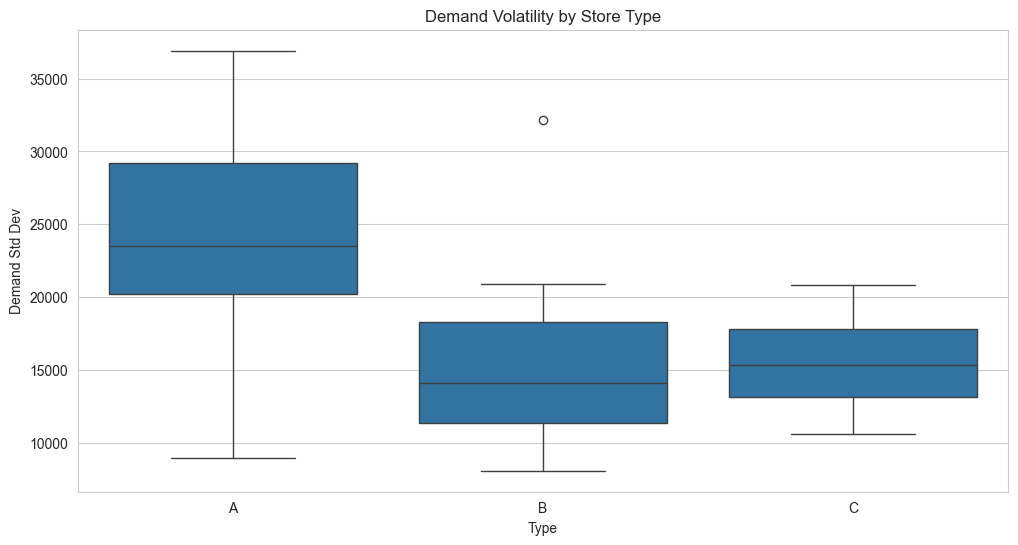

In [30]:
store_vol = (
    eda_df
    .groupby(["Store", "Type"])["Weekly_Sales"]
    .std()
    .reset_index()
)

sns.boxplot(x="Type", y="Weekly_Sales", data=store_vol)
plt.title("Demand Volatility by Store Type")
plt.ylabel("Demand Std Dev")
plt.show()


### Observation.
Demand volatility varies markedly by store type, with some store types exhibiting consistently higher standard deviations than others.

### Interpretation.
Risk exposure is structurally uneven across the system. Even if average demand is similar, uncertainty profiles differ substantially depending on store characteristics.

### Implication.
Inventory decisions that ignore structural volatility differences are prone to silent degradation, as risk accumulates unevenly without triggering aggregate alarms.

# Rolling Demand vs Consumer Price Index (CPI)

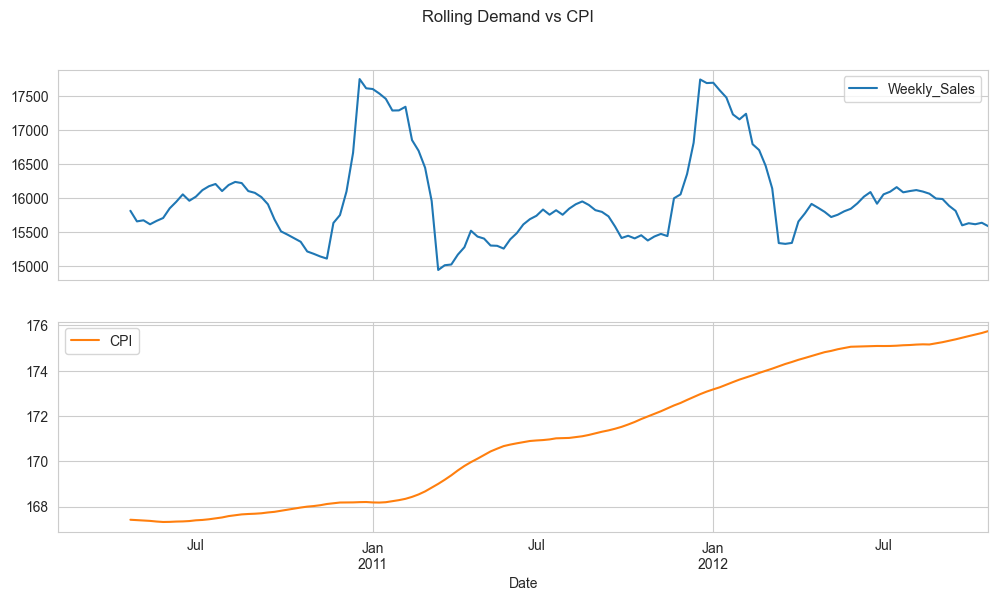

In [31]:
rolling = (
    eda_df
    .groupby("Date")[["Weekly_Sales", "CPI"]]
    .mean()
    .rolling(12)
    .mean()
)

rolling.plot(subplots=True, figsize=(12, 6))
plt.suptitle("Rolling Demand vs CPI")
plt.show()


### Observation.
CPI evolves smoothly over time, while rolling average demand exhibits sharper fluctuations and abrupt changes.

### Interpretation.
Macroeconomic indicators such as CPI operate on slower timescales and do not directly track short-term operational demand dynamics. Demand reacts through nonlinear and delayed mechanisms.

### Implication.
Using slow-moving economic signals to guide short-term inventory decisions can introduce lag-induced errors and mask emerging decision misalignment.

# Demand Distribution Across Fuel Price Regimes

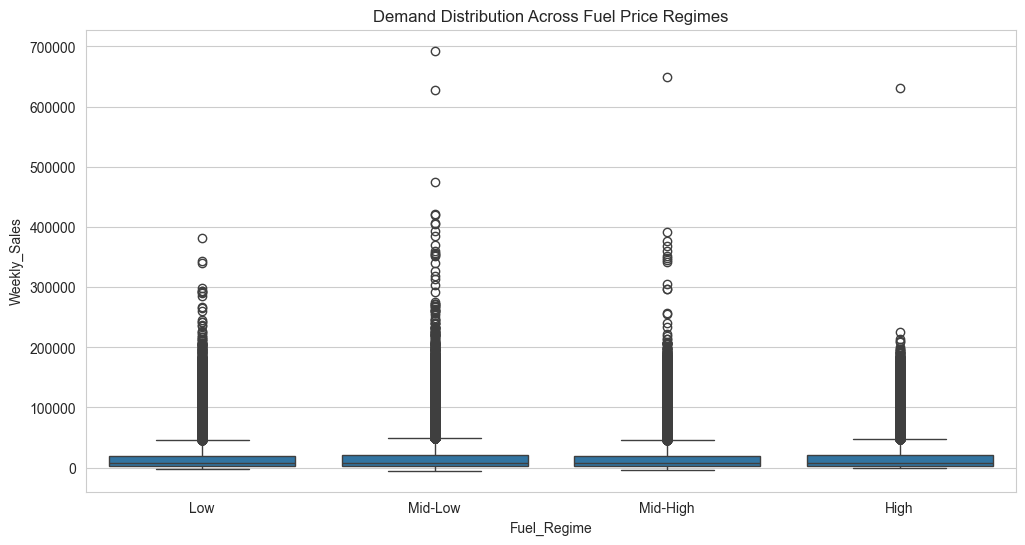

In [32]:
fuel_bins = pd.qcut(eda_df["Fuel_Price"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

eda_df["Fuel_Regime"] = fuel_bins

sns.boxplot(x="Fuel_Regime", y="Weekly_Sales", data=eda_df)
plt.title("Demand Distribution Across Fuel Price Regimes")
plt.show()


### Observation.
Demand distributions across fuel price regimes show overlapping ranges and similar dispersion patterns, with no clear monotonic relationship between fuel price level and demand.

### Interpretation.
Fuel price acts as a weak contextual signal rather than a direct driver of demand. Its influence is indirect and mediated through other factors.

### Implication.
Decision rules that assume direct sensitivity to fuel price regimes risk overinterpreting noise and underestimating latent demand drivers.

## Summary Insight from Combined EDA

Across all combined analyses, demand behavior emerges as the result of multiple weak, drifting, and partially observable signals, interacting with structural heterogeneity across stores and products. No single exogenous variable or structural attribute sufficiently explains demand outcomes. This environment creates conditions where inventory decision systems can remain operationally plausible while gradually becoming misaligned — a prerequisite for silent decision degradation.

# EDA 5 — Network-Based Structural Analysis

### Network 1: Store–Department Bipartite Network (Demand Weight)

In [46]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.


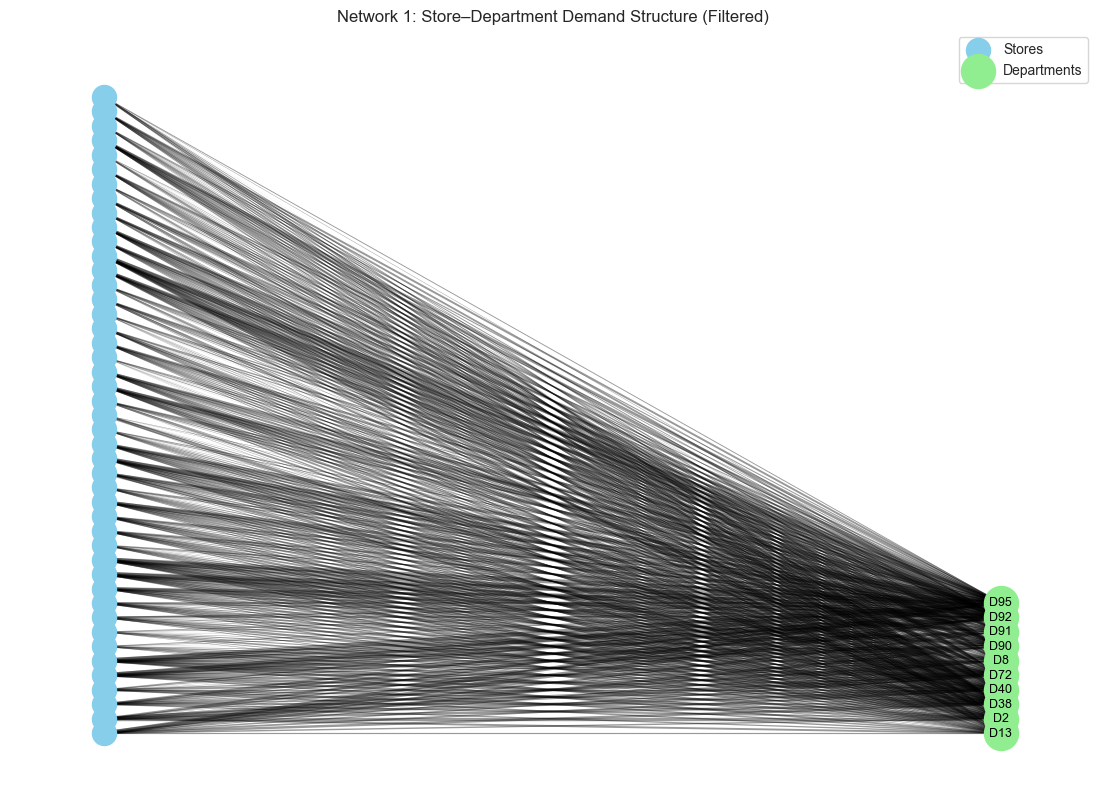

In [50]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Aggregate Store–Dept demand
# -----------------------------
sd_agg = (
    train.groupby(["Store", "Dept"])["Weekly_Sales"]
    .sum()
    .reset_index()
)

# -----------------------------
# Step 2: Select TOP departments (structural hubs)
# -----------------------------
TOP_K_DEPTS = 10

top_depts = (
    sd_agg.groupby("Dept")["Weekly_Sales"]
    .sum()
    .nlargest(TOP_K_DEPTS)
    .index
)

filtered = sd_agg[sd_agg["Dept"].isin(top_depts)]

# -----------------------------
# Step 3: Build bipartite graph
# -----------------------------
B = nx.Graph()

for _, row in filtered.iterrows():
    store = f"S{int(row['Store'])}"
    dept  = f"D{int(row['Dept'])}"
    B.add_edge(store, dept, weight=row["Weekly_Sales"])

# -----------------------------
# Step 4: Bipartite layout
# -----------------------------
stores = [n for n in B.nodes if n.startswith("S")]
depts  = [n for n in B.nodes if n.startswith("D")]

pos = {}

# place stores on left
for i, s in enumerate(sorted(stores)):
    pos[s] = (0, i)

# place departments on right
for i, d in enumerate(sorted(depts)):
    pos[d] = (5, i)

# -----------------------------
# Step 5: Draw the network
# -----------------------------
plt.figure(figsize=(14, 10))

# nodes
nx.draw_networkx_nodes(
    B, pos,
    nodelist=stores,
    node_color="skyblue",
    node_size=300,
    label="Stores"
)

nx.draw_networkx_nodes(
    B, pos,
    nodelist=depts,
    node_color="lightgreen",
    node_size=600,
    label="Departments"
)

# edges (scaled by demand)
weights = [B[u][v]["weight"] for u, v in B.edges()]
weights = [w / max(weights) * 4 for w in weights]

nx.draw_networkx_edges(
    B, pos,
    width=weights,
    alpha=0.4
)

# labels (only departments for clarity)
nx.draw_networkx_labels(
    B, pos,
    labels={n: n for n in depts},
    font_size=9
)

plt.title("Network 1: Store–Department Demand Structure (Filtered)")
plt.axis("off")
plt.legend(scatterpoints=1)
plt.show()


In [51]:
import pandas as pd
import networkx as nx

# -----------------------------------
# Step 1: Aggregate demand by Store–Department
# -----------------------------------
sd_agg = (
    train.groupby(["Store", "Dept"])["Weekly_Sales"]
    .sum()
    .reset_index()
)

# -----------------------------------
# Step 2: Build bipartite Store–Department graph
# -----------------------------------
B = nx.Graph()

for _, row in sd_agg.iterrows():
    store_node = f"S_{int(row['Store'])}"
    dept_node  = f"D_{int(row['Dept'])}"
    B.add_edge(store_node, dept_node, weight=row["Weekly_Sales"])

# -----------------------------------
# Step 3: Degree analysis (structural hubs)
# -----------------------------------
degree_df = pd.DataFrame(
    [(n, d) for n, d in B.degree()],
    columns=["node", "degree"]
)

degree_df["node_type"] = degree_df["node"].str[0]  # S or D

degree_summary = degree_df.groupby("node_type")["degree"].describe()

print("Degree Summary by Node Type")
print(degree_summary)

# -----------------------------------
# Step 4: Department reach (systemic exposure)
# -----------------------------------
dept_reach = (
    train.groupby("Dept")["Store"]
    .nunique()
    .sort_values(ascending=False)
)

print("\nTop Departments by Store Reach")
print(dept_reach.head(10))

# -----------------------------------
# Step 5: Store dependency on top departments
# -----------------------------------
TOP_K = 8

top_depts = (
    train.groupby("Dept")["Weekly_Sales"]
    .sum()
    .nlargest(TOP_K)
    .index
)

store_total_sales = train.groupby("Store")["Weekly_Sales"].sum()

store_top_sales = (
    train[train["Dept"].isin(top_depts)]
    .groupby("Store")["Weekly_Sales"]
    .sum()
)

store_dependency = (store_top_sales / store_total_sales).fillna(0)

dependency_summary = store_dependency.describe()

print("\nStore Dependency on Top Departments (fraction of demand)")
print(dependency_summary)

# -----------------------------------
# Step 6: Optional — save metrics for report use
# -----------------------------------
degree_df.to_csv("network1_node_degrees.csv", index=False)
dept_reach.to_csv("network1_department_reach.csv")
store_dependency.to_csv("network1_store_dependency.csv")


Degree Summary by Node Type
           count       mean       std   min   25%   50%   75%   max
node_type                                                          
D           81.0  41.123457  9.161581   1.0  43.0  45.0  45.0  45.0
S           45.0  74.022222  5.654800  61.0  74.0  77.0  77.0  79.0

Top Departments by Store Reach
Dept
1     45
2     45
3     45
4     45
5     45
6     45
7     45
8     45
9     45
10    45
Name: Store, dtype: int64

Store Dependency on Top Departments (fraction of demand)
count    45.000000
mean      0.418969
std       0.078342
min       0.293237
25%       0.377854
50%       0.400977
75%       0.436232
max       0.629160
Name: Weekly_Sales, dtype: float64


Network 2 : Store Similarity Network (Demand Correlation)

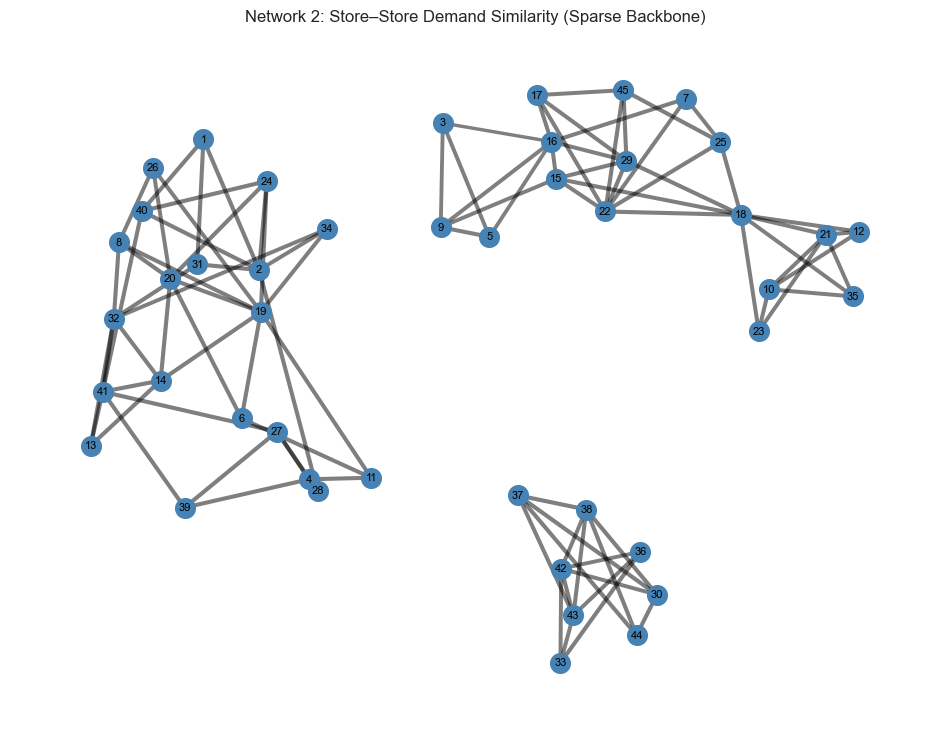

In [48]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Store × Dept matrix
# -----------------------------
pivot = train.pivot_table(
    index="Store",
    columns="Dept",
    values="Weekly_Sales",
    aggfunc="sum",
    fill_value=0
)

X = pivot.values.astype(float)

# -----------------------------
# Step 2: Manual cosine similarity
# -----------------------------
norms = np.linalg.norm(X, axis=1, keepdims=True)
X_norm = X / (norms + 1e-8)

similarity = X_norm @ X_norm.T

sim_df = pd.DataFrame(
    similarity,
    index=pivot.index,
    columns=pivot.index
)

# -----------------------------
# Step 3: Sparse graph (top-K)
# -----------------------------
TOP_K = 3
THRESHOLD = 0.6

G = nx.Graph()

for store in sim_df.index:
    sims = (
        sim_df.loc[store]
        .drop(store)
        .sort_values(ascending=False)
        .head(TOP_K)
    )
    for other, weight in sims.items():
        if weight > THRESHOLD:
            G.add_edge(store, other, weight=weight)

# -----------------------------
# Step 4: Draw network
# -----------------------------
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, seed=42, k=0.6)

weights = [G[u][v]["weight"] * 3 for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=200, node_color="steelblue")
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network 2: Store–Store Demand Similarity (Sparse Backbone)")
plt.axis("off")
plt.show()


### Network 3: Department Volatility Network

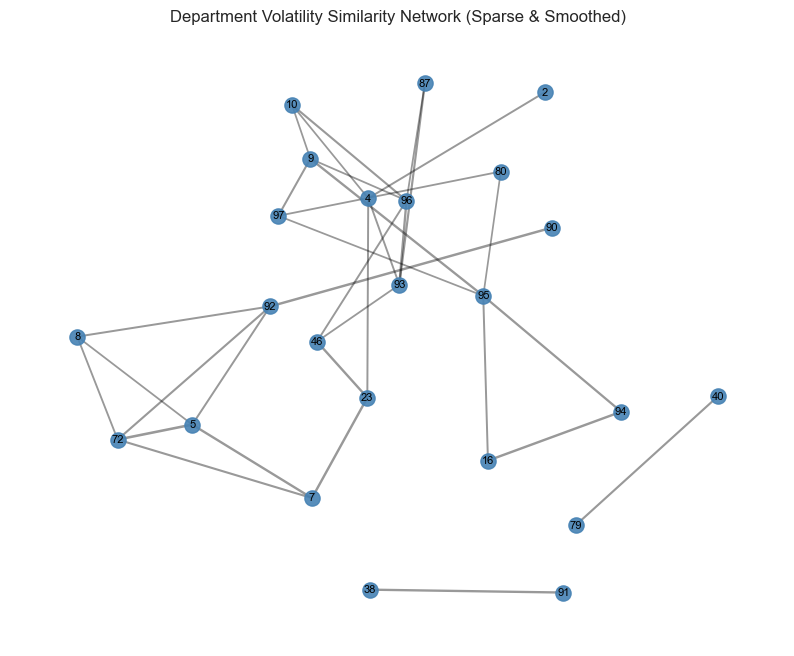

In [52]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. Compute department-level volatility (smoothed)
# -------------------------------------------------
dept_vol = (
    train
    .groupby(["Date", "Dept"])["Weekly_Sales"]
    .std()
    .unstack()
)

# Smooth volatility to reduce noise
dept_vol_smooth = dept_vol.rolling(window=8, min_periods=4).mean()

# -------------------------------------------------
# 2. Reduce dimensionality (keep informative depts)
# -------------------------------------------------
# Keep departments with high average volatility
vol_strength = dept_vol_smooth.mean()
top_depts = vol_strength.sort_values(ascending=False).head(25).index

dept_vol_reduced = dept_vol_smooth[top_depts]

# -------------------------------------------------
# 3. Correlation matrix
# -------------------------------------------------
dept_corr = dept_vol_reduced.corr()

# -------------------------------------------------
# 4. Build sparse network (top-k edges per node)
# -------------------------------------------------
Gd = nx.Graph()

TOP_K = 3
CORR_THRESHOLD = 0.6

for dept in dept_corr.columns:
    strongest = (
        dept_corr[dept]
        .drop(dept)
        .sort_values(ascending=False)
        .head(TOP_K)
    )
    
    for other, weight in strongest.items():
        if weight > CORR_THRESHOLD:
            Gd.add_edge(dept, other, weight=weight)

# -------------------------------------------------
# 5. Draw clean network
# -------------------------------------------------
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(Gd, seed=42, k=0.8)

weights = [Gd[u][v]["weight"] * 2 for u, v in Gd.edges()]

nx.draw_networkx_nodes(
    Gd, pos,
    node_size=120,
    node_color="steelblue",
    alpha=0.9
)

nx.draw_networkx_edges(
    Gd, pos,
    width=weights,
    alpha=0.4
)

nx.draw_networkx_labels(
    Gd, pos,
    font_size=8
)

plt.title("Department Volatility Similarity Network (Sparse & Smoothed)")
plt.axis("off")
plt.show()



### Network 4: Shock Propagation Proxy Network (Holiday Sensitivity)

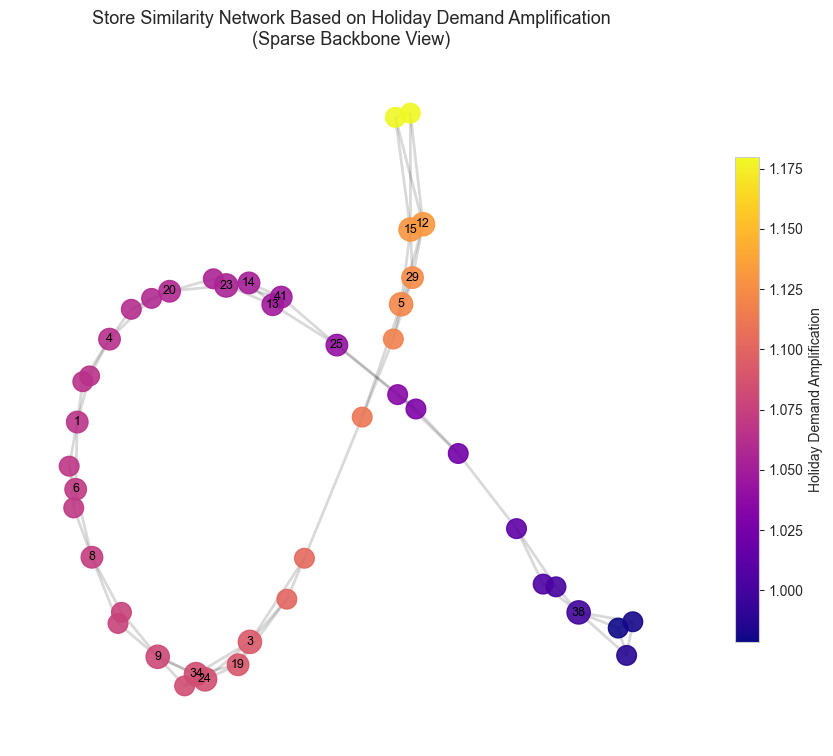

In [55]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# -------------------------------------------------
# 1. Compute holiday amplification per store
# -------------------------------------------------
holiday_amp = (
    eda_df
    .groupby(["Store", "IsHoliday_x"])["Weekly_Sales"]
    .mean()
    .unstack()
)

# Remove stores with missing holiday/non-holiday data
holiday_amp = holiday_amp.dropna()

holiday_amp["amplification"] = (
    holiday_amp[True] / holiday_amp[False]
)

# Optional: clip extreme ratios (robustness)
holiday_amp["amplification"] = holiday_amp["amplification"].clip(0.5, 3.0)

# -------------------------------------------------
# 2. Build similarity network (k-nearest)
# -------------------------------------------------
Gs = nx.Graph()

TOP_K = 3
MAX_DIFF = 0.15

stores = holiday_amp.index
amps = holiday_amp["amplification"]

for store in stores:
    diffs = (amps - amps.loc[store]).abs()
    nearest = diffs.sort_values().iloc[1:TOP_K+1]

    for other, diff in nearest.items():
        if diff < MAX_DIFF:
            weight = 1 / (diff + 1e-4)
            Gs.add_edge(store, other, weight=weight)
# -------------------------------------------------
# 4. Clean visualization (BACKBONE view)
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(
    Gs,
    seed=42,
    k=1.3,
    iterations=80
)

degrees = dict(Gs.degree())
node_sizes = [80 + degrees[n] * 40 for n in Gs.nodes()]

amp_map = holiday_amp["amplification"]
node_colors = [amp_map.loc[n] for n in Gs.nodes()]

edge_weights = [Gs[u][v]["weight"] for u, v in Gs.edges()]
edge_widths = [min(2, w * 0.2) for w in edge_weights]

nx.draw_networkx_edges(
    Gs,
    pos,
    ax=ax,
    width=edge_widths,
    alpha=0.15,
    edge_color="black"
)

nodes = nx.draw_networkx_nodes(
    Gs,
    pos,
    ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    cmap="plasma",
    alpha=0.9
)

labels = {n: n for n, d in degrees.items() if d >= 4}
nx.draw_networkx_labels(
    Gs,
    pos,
    ax=ax,
    labels=labels,
    font_size=9
)

ax.set_title(
    "Store Similarity Network Based on Holiday Demand Amplification\n"
    "(Sparse Backbone View)",
    fontsize=13
)

ax.axis("off")

# ---- PROPER COLORBAR ----
norm = Normalize(
    vmin=min(node_colors),
    vmax=max(node_colors)
)

sm = ScalarMappable(norm=norm, cmap="plasma")
sm.set_array([])

fig.colorbar(
    sm,
    ax=ax,
    shrink=0.7,
    label="Holiday Demand Amplification"
)

plt.show()



## 1️⃣ Bipartite Store–Department Network (the “fan-shaped monster”)

**What you see**

* Stores on one side, departments on the other
* Almost every store connects to the same set of departments
* Dense, triangular “fan” pattern

**What it means**

* This is not a visualization failure.
* This is structural **overlap dominance**.

Interpretation you should write:

> Most stores share a common core of high-volume departments. The decision system therefore operates under **strong coupling**, where changes in a small subset of departments propagate to nearly all stores.

This is **important**, because it tells you:

* Inventory decisions are **not independent per store**
* Local errors can propagate system-wide
* Static heuristics are fragile

This network is **evidence**, not a model.

---

## 2️⃣ Store–Store Demand Similarity Network (Sparse Backbone)

**What you see**

* Clear clusters of stores
* Several disconnected components
* Reasonable spacing and interpretable structure

**What it means**

* Stores naturally group by demand dynamics
* The system has **latent regimes**
* One-size-fits-all decision rules are structurally wrong

Key sentence for your report:

> Store-level demand similarity reveals stable clusters, indicating heterogeneous operational regimes that a single global decision policy cannot optimally serve.

This network becomes your **baseline structural context**.

---

## 3️⃣ Department Volatility Similarity Network (Sparse & Weak)

**What you see**

* Few links
* Fragmented structure
* No dominant cluster

**What it means**

* Department volatility is largely **independent**
* Volatility alone does *not* encode system structure

This is a **negative result**, and that’s powerful.

Correct framing:

> Even after smoothing, department-level volatility does not exhibit strong inter-departmental coupling, suggesting that volatility alone is insufficient to characterize decision dependencies.

This justifies **why your project cannot rely on static statistics**.

---

## 4️⃣ Holiday Amplification Network (Cleaned, Colored)

This is your **best behavioral network**.

**What you see**

* A gradient (low → high amplification)
* Partial chains and small clusters
* No global synchronization

**What it means**

* Holiday effects are **store-specific**
* Some stores are systematically more sensitive
* Decision degradation can begin *here* if the system assumes uniform amplification

Key insight:

> Holiday demand amplification acts as a behavioral fingerprint rather than a universal seasonal multiplier.

This is a **future degradation trigger**.

---

## 5️⃣ Degree & Dependency Statistics (this is gold)

### Degree Summary

* Departments connect to almost all stores
* Stores connect to many departments

This tells you:

* The system is **densely coupled**
* Failures can cascade silently

### Top Departments by Store Reach

* Dept 1–10 touch *every* store

Interpretation:

> A small subset of departments dominates system-wide demand exposure, creating hidden single points of failure in inventory decisions.

### Store Dependency Fraction

* Mean ≈ **42%** of demand depends on top departments
* Max ≈ **63%**

That’s huge.

This one line alone can justify your FYP:

> Nearly half of store demand is concentrated in a small department subset, amplifying the risk of silent decision degradation when conditions shift.

---
